In [48]:
from Headers.TwitterCommunicator import *
from Headers.Payoff.PayoffCalculator import *
from Headers.Payoff.DataCruncher import *
from Headers.NetworkData import *

import networkx as nx
import math
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [49]:
numAdopters = 6 #This is the number of initial adopters, or the number of people you are willing to give 'free samples' to,
                #for publicizing your product. Change this number to obtain different results for this case.

In [50]:
#Returns a generator object to generate all the combinations of a given size from a set of items. It is used for the brute force
#search of the best initial adopters.
def allCombinations(items, n):
    if n==0: yield []
    else:
        for i in xrange(len(items)):
            for cc in allCombinations(items[i+1:],n-1):
                yield [items[i]]+cc

#Method to draw graph
def draw_graph(graph):
    layout = nx.circular_layout(graph)
    plt.figure()
    nodes = graph.nodes()
    colors = ['r' if graph.node[n]['choice'] == 'A' else 'b'
              for n in graph]
    plt.axis('off')
    nx.draw_networkx(graph, nodelist=nodes, with_labels=True,
                     width=1, node_color=colors,alpha=.5,
                     pos=layout)

#Takes in a list of nodes and sets them as initial adopters in the input graph
def setAdopters(graph, adopters):
    for a in adopters:
        graph.node[a]['choice']='A'

#This method actually does the cascade simulation for one cascade iteration. Here, the calculated payoff is used
#instead of the traditional payoff.
def doCascade(graph, adopters):
    newAdopterCount = 0
    adoptingFriends = []
    for v in graph:
        if graph.node[v]['choice'] == 'B':
            a_neighbors = [w for w in graph.neighbors(v)
                           if graph.node[w]['choice'] == 'A']
            b_neighbors = [w  for w in graph.neighbors(v)
                           if graph.node[w]['choice'] == 'B']
            p = 1. * len(a_neighbors) / (len(a_neighbors) + len(b_neighbors))
            q = 1 - graph.node[v]['payoff']
            if p >= q:
                graph.node[v]['choice'] = 'A'
                adoptingFriends.append(v)
                newAdopterCount = newAdopterCount + 1

    return (adoptingFriends, newAdopterCount)

In [51]:
tags = ['celebrity', 'famous', 'party'] #Word Tags used for current data set. It has been assumed that the product to be 
                                        #publicized is an app pertaining to gossip talks and celebrity lives, parties etc

#Reading datasets from stored files

nData = NetworkData()
nData.loadFriendNetworkData('dump_friendNetworks_this.txt') #This is the record of friends of the user and the friends/pages
                                                            #which they are following. This is used to calculate the payoffs
                                                            #and make the final suggestions.

pCalc = PayoffCalculator(nData, tags)
pCalc.loadPayoffs(fileName='dump_payoffs_this.txt') #Loading payoffs for each friend, previously computed and stored using pickle
                                                    #This process is time consuming and can take up to 4-5 hours.

#Filtering out inconsistent and irrelevant entries and payoffs
for key in pCalc.payOffs.keys():
     if math.isnan(pCalc.payOffs[key]) or pCalc.payOffs[key] == 0:
         del pCalc.payOffs[key]

In [ ]:
friendGraph = nx.Graph()

#Creating graph objects out of friend network
for friend in pCalc.payOffs.keys():
    friendsOfFriend_tObjects = list(nData.friendNetworks[friend].get_iterator())
    friendsOfFriend_snames = [k['screen_name'] for k in friendsOfFriend_tObjects]
    myOtherFriends_snames = list(pCalc.payOffs.keys())
    myOtherFriends_snames = [x for x in myOtherFriends_snames if x is not friend]
    for f in friendsOfFriend_snames:
        if f in myOtherFriends_snames:
            friendGraph.add_edge(friend, f)

#Setting default attributes of the graph. Here, behavior 'A' corresponds to favoring the user's product and
#behavior 'B' corresponds to the opposite of that.
nx.set_node_attributes(friendGraph, 'payoff', 0.)
nx.set_node_attributes(friendGraph, 'choice', 'B') #Initially we assume nobody is in favour.

#Populate the Graph node attributes with previously computed payoffs.
for n in friendGraph.nodes():
    friendGraph.node[n]['payoff'] = pCalc.payOffs[n]

#Identify and separate disjoint sets of friends of users (if any)
clusters = list(nx.connected_component_subgraphs(friendGraph))
cluster_sizes = [len(c.nodes()) for c in clusters]
cluster_sizeMap = zip(clusters, cluster_sizes)
clusterCount = len(clusters)

clusterSpreads = []
clusterAdopters = []
clusterInfections = []
clusterSets = []

In [ ]:
#Probing each cluster in a brute-force manner to enumerate the sets of initial adopters of behavior 'A' which shall 
#penetrate the most. We basically try all possible combinations of initial adopters and select the one which
#results in a maximum spread of behavior 'A'
for cluster in clusters:
    l = nx.spring_layout(cluster)
    numNodes = len(cluster.nodes())

    if numAdopters <= numNodes:
        possibleAdopters = list(allCombinations(cluster.nodes(), numAdopters))

        maxSpread = 0
        maxAdopters = []
        maxInfected = []
        maxCluster = None

        nAdopters = len(possibleAdopters)
        i = 1
        for ad in possibleAdopters:
            print 'Progress =', i, '/', nAdopters
            nx.set_node_attributes(cluster, 'choice', 'B')
            setAdopters(cluster, ad)
            newSpread = 0 #Number of newly infected
            newInfected = [] #Names of all newly infected
            while True:
                newAdopters = doCascade(cluster, ad)
                newSpread = newSpread + newAdopters[1]
                if newAdopters[1] > 0:
                    newInfected += newAdopters[0]
                if newAdopters[1] == 0:
                    break
            if newSpread > maxSpread:
                maxSpread = newSpread
                maxAdopters = ad
                maxInfected = newInfected
                maxCluster = cluster.copy()

            print 'Max Spread =', maxSpread #Maximum number of nodes up to which behavior 'A' has spread.

            if (newSpread + numAdopters) == numNodes:
                break
            i = i + 1

        clusterSpreads.append(maxSpread)
        clusterAdopters.append(maxAdopters)
        clusterInfections.append(maxInfected)
        clusterSets.append(maxCluster)

results = zip(clusterSets, clusterSpreads, clusterAdopters, clusterInfections)
with open('results_this.txt', 'wb') as fl: #Dumping results on to Hard Disk as it is time-consuming to compute
    pickle.dump(results, fl)

Progress = 1 / 74613
Max Spread = 2
Progress = 2 / 74613
Max Spread = 2
Progress = 3 / 74613
Max Spread = 3
Progress = 4 / 74613
Max Spread = 3
Progress = 5 / 74613
Max Spread = 3
Progress = 6 / 74613
Max Spread = 3
Progress = 7 / 74613
Max Spread = 3
Progress = 8 / 74613
Max Spread = 3
Progress = 9 / 74613
Max Spread = 3
Progress = 10 / 74613
Max Spread = 4
Progress = 11 / 74613
Max Spread = 4
Progress = 12 / 74613
Max Spread = 4
Progress = 13 / 74613
Max Spread = 4
Progress = 14 / 74613
Max Spread = 4
Progress = 15 / 74613
Max Spread = 4
Progress = 16 / 74613
Max Spread = 4
Progress = 17 / 74613
Max Spread = 4
Progress = 18 / 74613
Max Spread = 4
Progress = 19 / 74613
Max Spread = 4
Progress = 20 / 74613
Max Spread = 4
Progress = 21 / 74613
Max Spread = 4
Progress = 22 / 74613
Max Spread = 4
Progress = 23 / 74613
Max Spread = 4
Progress = 24 / 74613
Max Spread = 4
Progress = 25 / 74613
Max Spread = 4
Progress = 26 / 74613
Max Spread = 4
Progress = 27 / 74613
Max Spread = 4
Progress =

In [ ]:
with open('results_this.txt', 'rb') as fl:
    results = pickle.load(fl)

Found a total of 4 cluster(s) of size(s) [22, 7, 3, 2] -


Result 1

Cluster size = 22
User ids of initial adopters resulting in max spread in this cluster - [u'Deepanshu2014Dt', u'kulbeer_sidhu', u'Funnyoneliners', u'sapan_u', u'coolnitesh09', u'manoharvvgolla']

Spread Amount (Number of people spread to, apart from initial adopters) = 9
User ids of people spread to- [u'kulllshubh', u'Dracodos', u'TheTeKKI', u'VineetMshr', u'Shiwani14393', u'manishjha_', u'shkkonda', u'VibhoreAgarwal1', u'Raven_krishna']

Result 2

Cluster size = 7
User ids of initial adopters resulting in max spread in this cluster - [u'Samarthsetia', u'StraightFaces', u'limbicpoet', u'DrkLrdMistress', u'NutterDiaries', u'arjunsaxena55']

Spread Amount (Number of people spread to, apart from initial adopters) = 1
User ids of people spread to- [u'bigbacontheory']


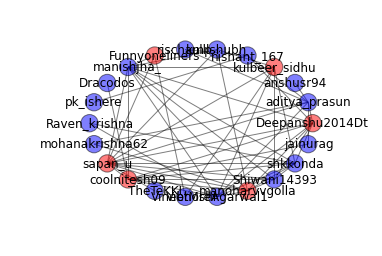

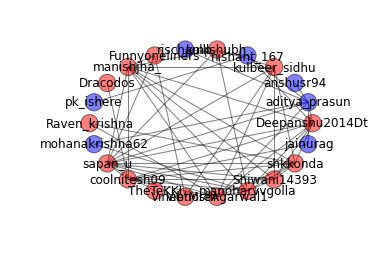

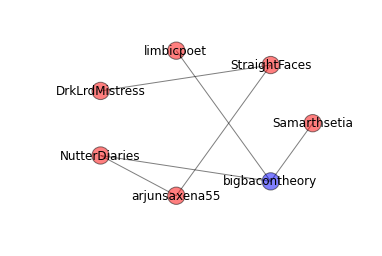

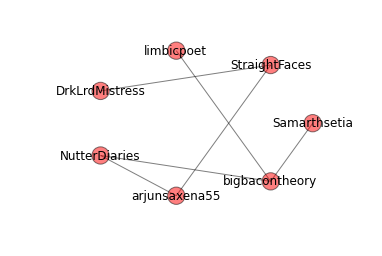

In [57]:
i = 0
print 'Found a total of', clusterCount, 'cluster(s) of size(s)', cluster_sizes, '-\n'

#Printing out results which include the candidate clusters in which sufficient numbers of initial adopters have been identified
#to cause high cascading. The graphs are presented at the end of the textual result. 
#Two graphs correspond to each result; the first one highlighting the initial adopters and the second one highlighting the nodes
#to which behavior 'A' spreads after cascading.
for result in results:
    print '\nResult', i+1
    print '\nCluster size =', len(result[0].nodes())
    clust_tmp = result[0].copy()
    nx.set_node_attributes(clust_tmp, 'choice', 'B')
    for adops in result[2]:
        clust_tmp.node[adops]['choice'] = 'A'
    #print 'Initial Adopters for max. spread -'
    draw_graph(clust_tmp)
    #nx.draw(clust_tmp)
    print 'User ids of initial adopters resulting in max spread in this cluster -', result[2]
    print ''
    #print 'Graph after behavior pentration-'
    draw_graph(result[0])
    #nx.draw(result[0])
    print 'Spread Amount (Number of people spread to, apart from initial adopters) =', result[1]
    print 'User ids of people spread to-', result[3]
    i = i + 1

In [58]:
#Printing the final set of initial adopters which shall result in the maximum spread of behavior 'A' in the overall friend 
#network
finalMaxSpread = 0
finalAdopterSet = []
for result in results:
    if result[1] > finalMaxSpread:
        finalMaxSpread = result[1]
        finalAdopterSet = result[2]
        
print 'Suggested set of intial adopters for maximum penetration -', finalAdopterSet

Suggested set of intial adopters for maximum penetration - [u'Deepanshu2014Dt', u'kulbeer_sidhu', u'Funnyoneliners', u'sapan_u', u'coolnitesh09', u'manoharvvgolla']
